In [1]:
# %load_ext autoreload
# # Enable autoreload for all modules
# %autoreload 2

In [2]:
from iris_environments.environments import get_environment_builder
import numpy as np
import ipywidgets as widgets
from functools import partial
from pydrake.all import (RigidTransform, Rgba, Sphere, RotationMatrix)

In [3]:
from functools import partial
from pydrake.all import (StartMeshcat,
                         RobotDiagramBuilder,
                         MeshcatVisualizer,
                         LoadModelDirectives,
                         ProcessModelDirectives,
                         RigidTransform,
                         RotationMatrix,
                         MeshcatVisualizerParams,
                         Role,
                         RollPitchYaw,
                         Meldis,
                         AddDefaultVisualization,
                         Box
                         )
import numpy as np
import os

def plant_builder_7dof_bins(usemeshcat = False):
    if usemeshcat:
        #meshcat = StartMeshcat()
        meldis = Meldis()
        meshcat = meldis.meshcat
    builder = RobotDiagramBuilder()
    plant = builder.plant()
    scene_graph = builder.scene_graph()
    parser = builder.parser()
    #parser.package_map().Add("cvisirisexamples", missing directory)
    file_p = "/home/peter/gitcspace/iris_benchmarks/iris_environments"
    directives_file = file_p+"/directives/7dof_bins_example_urdf.yaml"#FindResourceOrThrow() 
    # directives_file = file_p+"/directives/7dof_bins_example.yaml"#FindResourceOrThrow() 
    path_repo = file_p #os.path.dirname(os.path.abspath(__file__))
    parser.package_map().Add("iris_environments", path_repo+"/assets")
    directives = LoadModelDirectives(directives_file)
    models = ProcessModelDirectives(directives, plant, parser)
    plant.Finalize()
    if usemeshcat:
        #par = MeshcatVisualizerParams()
        #par.role = Role.kIllustration
        #visualizer = MeshcatVisualizer.AddToBuilder(builder.builder(), scene_graph, meshcat, par)
        visualizer = AddDefaultVisualization(builder.builder(), meshcat)
    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    diagram.ForcedPublish(diagram_context)
    return plant, scene_graph, diagram, diagram_context, plant_context, meshcat if usemeshcat else None



In [4]:
import sys
path_repo = "/home/peter/gitcspace/iris_benchmarks/iris_environments"
sys.path.append('/home/peter/gitcspace/cuciv0/bazel-bin/cuci/src/pybind/pycuci')
import pycuci_bindings as pycuci
cuci_parser = pycuci.URDFParser()
cuci_parser.register_package("iris_environments",  path_repo + "/assets/")
cuci_parser.parse_directives(path_repo+"/directives/7dof_bins_example_urdf.yaml")
pl = cuci_parser.build_plant()
kt = pl.getKinematicTree()
links = kt.get_links()
for l in links:
    print(l.name)

Successfully registered package 'iris_environments' with path: /home/peter/gitcspace/iris_benchmarks/iris_environments/assets/
world
iiwa::iiwa_link_0
iiwa::iiwa_link_1
iiwa::iiwa_link_2
iiwa::iiwa_link_3
iiwa::iiwa_link_4
iiwa::iiwa_link_5
iiwa::iiwa_link_6
iiwa::iiwa_link_7
wsg::body
wsg::left_finger
wsg::right_finger
iiwa::wsg_attach
shelves::shelves_body
shelves::top_and_bottom
shelf_origin
binR::bin_base
bin_originR
binL::bin_base
bin_originL
table::table_body
table_origin


In [5]:
from iris_environments.environments import env_names, get_robot_instance_names
from pydrake.all import SceneGraphCollisionChecker

currname = env_names[6]
plant_builder = get_environment_builder(currname)
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder_7dof_bins(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
robot_instances = get_robot_instance_names(currname)
checker = SceneGraphCollisionChecker(model = diagram, 
                                     robot_model_instances = [plant.GetModelInstanceByName(r) for r in robot_instances], 
                                     edge_step_size = 0.1)

INFO:drake:Meshcat listening for connections at http://localhost:7000
INFO:drake:Allocating contexts to support implicit context parallelism 20


# Run this cell and then use the sliders and the button to save the seed points

In [6]:


q = np.zeros(plant.num_positions()) 
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]*0.99
    q_high = plant.GetPositionUpperLimits()[i]*0.99
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, step=0.001, description=f"q{i}"))

col_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_free =  Rgba(0.0, 0.8, 0.5, 0.5) 
def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    query = plant.get_geometry_query_input_port().Eval(plant_context)
    col = query.HasCollisions()
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  np.array([0,0,2])))
    return col

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.9373894, min=-2.9373894, step=0.001)

FloatSlider(value=0.0, description='q1', max=2.0734559999999997, min=-2.0734559999999997, step=0.001)

FloatSlider(value=0.0, description='q2', max=2.9373894, min=-2.9373894, step=0.001)

FloatSlider(value=0.0, description='q3', max=2.0734559999999997, min=-2.0734559999999997, step=0.001)

FloatSlider(value=0.0, description='q4', max=2.9373894, min=-2.9373894, step=0.001)

FloatSlider(value=0.0, description='q5', max=2.0734559999999997, min=-2.0734559999999997, step=0.001)

FloatSlider(value=0.0, description='q6', max=3.0237867, min=-3.0237867, step=0.001)

In [10]:
from pydrake.all import HPolyhedron
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits())
cuci_domain = pycuci.HPolyhedron(domain.A(), domain.b())

In [16]:

import time
import pickle
t1 = time.time()
nodes = pycuci.UniformSampleInHPolyhedraCuda([cuci_domain], cuci_domain.ChebyshevCenter(), 100000, 100)[0]
is_col_free = pycuci.CheckCollisionFreeCuda(nodes, pl.getMinimalPlant())

N = 100
nodes = nodes[:, np.where(is_col_free)[0]]
nodes = nodes[:, :N]
print(f"found {nodes.shape[1]} collision-free nodes")
vg_cuci = pycuci.VisibilityGraph(nodes, pl.getMinimalPlant(), 0.1, 5000000)

with open(f'vg_7_dof_bins_uniform_{N}_upper_triangle_only.pkl', 'wb') as f:
    data = {'adjacency': vg_cuci, 'nodes': nodes}
    pickle.dump(data,f)
# t2 = time.time()
# print('pycuci done')
# vg_drake = VisibilityGraph(checker, nodes, parallelize=True)
# t3 = time.time()

# print(f"time cuci: {t2-t1:.3f} \ntime drake: {t3 - t2: .3f}")
# for i in range(0, vg_cuci.shape[1]-1):
#     for j in range(i+1, vg_cuci.shape[1]):
#         assert(vg_cuci[i,j] == vg_drake[i,j])

execution time cuda no copy: 4 ms
execution time cuda no copy: 3 ms
found 100 collision-free nodes
num batches 1 
 num_edges_per_batch 4950 
, num_edges_to_check 4950 
time to insert results in matrix: 0 ms


In [17]:
import pickle
with open('tmp/7dof_bin_tsseeding_4000_0.05_1337.pkl', 'rb') as f:
    data = pickle.load(f)


In [18]:
q_tot = np.concatenate(tuple(data['q_obj']), axis = 0)

In [31]:
import time
import pickle
t1 = time.time()
# nodes = pycuci.UniformSampleInHPolyhedraCuda([cuci_domain], cuci_domain.ChebyshevCenter(), 100000, 100)[0]
# is_col_free = pycuci.CheckCollisionFreeCuda(nodes, pl.getMinimalPlant())

N = 4000
# pts_binL = q_tot[:int(N/3), :]
# pts_binR = q_tot[4000:4000+int(N/3), :]
# pts_shelf = q_tot[8000:8000+N-2*int(N/3), :]
ts_samples = q_tot[8000:8000+N, :]
# ts_samples = np.concatenate((pts_binL, pts_binR, pts_shelf), axis = 0)

vg_cuci = pycuci.VisibilityGraph(ts_samples.T, pl.getMinimalPlant(), 0.1, 5000000)

with open(f'tmp/vg_7_dof_bins_shelves_only_{N}_upper_triangle_only.pkl', 'wb') as f:
    data = {'adjacency': vg_cuci, 'nodes': ts_samples.T}
    pickle.dump(data,f)

num batches 177 
 num_edges_per_batch 45046 
, num_edges_to_check 7998000 
time to insert results in matrix: 187 ms


(100, 7)

In [22]:
# showres(q_tot[4005]*dir)
import time
for q in ts_samples:
    showres(q)
    time.sleep(0.1)
    

In [11]:
is_col_free = pycuci.CheckCollisionFreeCuda(q_tot.T, pl.getMinimalPlant())
np.all(is_col_free)

execution time cuda no copy: 12 ms


True

In [32]:
counter = 0
for i in range(0, vg_cuci.shape[1]-1):
    for j in range(i+1, vg_cuci.shape[1]):
        if vg_cuci[i,j] != vg_drake[i,j]:
            counter +=1

In [33]:
counter

1

In [34]:
vg_cuci.shape[1]*(vg_cuci.shape[1]-1)/2

2595781.0

In [15]:
is_col_free

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,


In [13]:
pycuci.CheckCollisionFree(q*0, pl.getMinimalPlant())

True

In [6]:
q = np.array([-8.30000e-03,  1.16796e+00,  9.16740e-01,  8.10270e-01,
        8.84370e-01,  1.15137e+00,  6.28890e-01,  6.30620e-01,
       -3.00000e-04,  3.74960e-01,  1.42774e+00,  5.89270e-01,
       -1.43300e-01,  5.32960e-01,  9.91740e-01,  6.33270e-01])

In [7]:
file.close()

# Inspect seed points

In [8]:
import yaml
import time

with open(seed_point_file, 'r') as f:
    seed_points = yaml.safe_load(f)
seed_points = np.array(seed_points['seedpoints'])

for i, s in enumerate(seed_points):
    showres(s)
    print(f" point {i+1} / {len(seed_points)}")
    time.sleep(2)


 point 1 / 10
 point 2 / 10
 point 3 / 10
 point 4 / 10
 point 5 / 10
 point 6 / 10
 point 7 / 10
 point 8 / 10
 point 9 / 10
 point 10 / 10


In [11]:
plant.GetBodyByName("")

RuntimeError: GetRigidBodyByName(): There is no RigidBody named '' anywhere in the model (valid names in model instance 'WorldModelInstance' are: world; valid names in model instance 'allegro_hand' are: hand_root, link_0, link_1, link_10, link_11, link_12, link_13, link_14, link_15, link_2, link_3, link_4, link_5, link_6, link_7, link_8, link_9; valid names in model instance 'block' are: block_body)

In [20]:
showres(seed_points[-3])

False

In [10]:
q

array([ 0.434544, -0.6944  ])

In [ ]:
import pymeshlab as ml

def save_tet_vtk(name, vertices, triangles, debug_viz = False):
    #fix non manifold vertices
    ms = ml.MeshSet()
    # Add vertices and faces to the MeshSet
    ms.add_mesh(ml.Mesh(vertices, triangles))
     # Apply filters to fix non-manifold mesh errors.
    ms.apply_filter('meshing_repair_non_manifold_edges')
    #ms.apply_filter('meshing_repair_non_manifold_vertices')
    mesh_fixed = ms.current_mesh()
    tet = tetgen.TetGen(mesh_fixed.vertex_matrix(), mesh_fixed.face_matrix())
    t1 = time.time()
    tet.tetrahedralize(quality=True, nobisect=True, nomergefacet=True,
                    nomergevertex=True, vtksurfview=True, vtkview=True,
                    verbose=True)
    t2 = time.time()
    path_vtk = path_tmp_dir + "/" + name + ".vtk"
    tet.write(path_vtk, binary=False)
    print(f"time {t2-t1}")

    #debugging visualization of tetmesh
    if debug_viz:
        grid = tet.grid
        grid.plot(show_edges = True)

    return path_vtk

INFO:drake:Meshcat listening for connections at http://localhost:7000


http://localhost:7000


INFO:drake:Meshcat listening for connections at http://localhost:7000


http://localhost:7000


In [20]:
import vhacdx
import trimesh
import os
import numpy as np

input_file = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/triangle_and_hole.obj"
output_dir = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp"
def save_obj(vertices, faces, filename):
    with open(filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
# def split_obj_with_vhacd(input_file, output_dir, max_convex_hulls=20):
# Load the mesh
mesh = trimesh.load_mesh(input_file)

# Perform V-HACD
convex_hulls = vhacdx.compute_vhacd(
    np.array(mesh.vertices.tolist()),
    np.array(mesh.faces.tolist(), dtype = np.uint32),
    maxConvexHulls=6,
    minimumVolumePercentErrorAllowed = 1.0,
    # resolution=1000000,
    # concavity=0.1,
    # planeDownsampling=4,
    # convexhullDownsampling=4,
    # alpha=0.05,
    # beta=0.05,
    # gamma=0.00125,
    # pca=0,
    # mode=0,
    # maxNumVerticesPerCH=64,
    # minVolumePerCH=0.0001
)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save each convex hull as a separate OBJ file
for i, hull in enumerate(convex_hulls):
    vertices, faces = hull
    output_file = os.path.join(output_dir, f"part_{i:03d}.obj")
    save_obj(vertices, faces, output_file)

print(f"Split {input_file} into {len(convex_hulls)} parts in {output_dir}")
# split_obj_with_vhacd(path, out)

Split /home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/triangle_and_hole.obj into 6 parts in /home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp


In [26]:
import vhacdx
import trimesh
import os
import numpy as np

def save_obj(vertices, faces, filename):
    with open(filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

def split_obj_with_vhacd(input_file, output_dir, **kwargs):
    # Load the mesh
    mesh = trimesh.load_mesh(input_file)
    
    print(f"Input mesh: {len(mesh.vertices)} vertices, {len(mesh.faces)} faces")
    print(f"Mesh volume: {mesh.volume}")
    print(f"Mesh bounding box: {mesh.bounding_box.extents}")

    # Default parameters
    params = {
        'maxConvexHulls': 64,
        'resolution': 400000,
        'minimumVolumePercentErrorAllowed': 1.0,
        'maxRecursionDepth': 10,
        'shrinkWrap': True,
        'fillMode': 'flood',
        'maxNumVerticesPerCH': 64,
        'asyncACD': True,
        'minEdgeLength': 2,
        'findBestPlane': False
    }

    # Update parameters with any provided kwargs
    params.update(kwargs)

    # Ensure vertices and faces are the correct dtype
    vertices = np.array(mesh.vertices, dtype=np.float64)
    faces = np.array(mesh.faces, dtype=np.uint32)

    # Perform V-HACD
    convex_hulls = vhacdx.compute_vhacd(
        points=vertices,
        faces=faces,
        **params
    )

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save each convex hull as a separate OBJ file
    for i, hull in enumerate(convex_hulls):
        vertices, faces = hull
        output_file = os.path.join(output_dir, f"part_{i:03d}.obj")
        save_obj(vertices, faces, output_file)
        
        # Create a trimesh object for the hull to calculate its properties
        hull_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        print(f"Hull {i}: {len(vertices)} vertices, {len(faces)} faces")
        print(f"Hull {i} volume: {hull_mesh.volume}")
        print(f"Hull {i} bounding box: {hull_mesh.bounding_box.extents}")

    print(f"Split {input_file} into {len(convex_hulls)} parts in {output_dir}")

# Example usage
input_file = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/outer_obs.STL"
output_dir = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp"

split_obj_with_vhacd(input_file, output_dir, 
                     resolution=2000000, 
                     maxConvexHulls=24, 
                     minimumVolumePercentErrorAllowed=0.1,  # Adjusted this parameter
                     maxRecursionDepth=20,  # Increased recursion depth
                     shrinkWrap=True,
                     fillMode='flood',
                     maxNumVerticesPerCH=64,
                     asyncACD=True,
                     minEdgeLength=2,
                     findBestPlane=True)  # Enable finding the best plane

Input mesh: 14 vertices, 28 faces
Mesh volume: 262.56851385838513
Mesh bounding box: [13.21312809  2.         13.21312809]
Hull 0: 21 vertices, 38 faces
Hull 0 volume: 5.921189464667501e-16
Hull 0 bounding box: [1.44008812 0.21797838 9.52216639]
Hull 1: 8 vertices, 12 faces
Hull 1 volume: 0.44702357342578625
Hull 1 bounding box: [0.82656193 0.23297165 9.65099251]
Hull 2: 13 vertices, 22 faces
Hull 2 volume: 1.2445974779005775
Hull 2 bounding box: [3.23074704 1.60133352 4.62292129]
Hull 3: 20 vertices, 36 faces
Hull 3 volume: 2.9605947323337506e-16
Hull 3 bounding box: [1.00287613 0.15179996 7.68108836]
Hull 4: 14 vertices, 24 faces
Hull 4 volume: 0.33138659528954373
Hull 4 bounding box: [1.35047194 0.48676466 1.73720932]
Hull 5: 15 vertices, 26 faces
Hull 5 volume: 0.3741521653631608
Hull 5 bounding box: [0.69877111 0.43805928 3.37213798]
Hull 6: 28 vertices, 52 faces
Hull 6 volume: 1.2266301978776835e-15
Hull 6 bounding box: [6.72129752 1.01736659 6.72129752]
Hull 7: 58 vertices, 112 

In [30]:
import vhacdx
import trimesh
import os
import numpy as np

def save_obj(vertices, faces, filename):
    with open(filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

def save_combined_obj(convex_hulls, filename):
    with open(filename, 'w') as f:
        vertex_offset = 0
        for i, (vertices, faces) in enumerate(convex_hulls):
            f.write(f"o Hull_{i}\n")
            for v in vertices:
                f.write(f"v {v[0]} {v[1]} {v[2]}\n")
            for face in faces:
                f.write(f"f {face[0]+vertex_offset+1} {face[1]+vertex_offset+1} {face[2]+vertex_offset+1}\n")
            vertex_offset += len(vertices)

def split_obj_with_vhacd(input_file, output_dir, **kwargs):
    # Load the mesh
    mesh = trimesh.load_mesh(input_file)
    output_file = os.path.join(output_dir, f"noop.obj")
    vertices = np.array(mesh.vertices, dtype=np.float64)
    faces = np.array(mesh.faces, dtype=np.uint32)
    save_obj(vertices, faces, output_file)
    
    print(f"Input mesh: {len(mesh.vertices)} vertices, {len(mesh.faces)} faces")
    print(f"Mesh volume: {mesh.volume}")
    print(f"Mesh bounding box: {mesh.bounding_box.extents}")

    # Default parameters
    params = {
        'maxConvexHulls': 64,
        'resolution': 400000,
        'minimumVolumePercentErrorAllowed': 1.0,
        'maxRecursionDepth': 10,
        'shrinkWrap': True,
        'fillMode': 'flood',
        'maxNumVerticesPerCH': 64,
        'asyncACD': True,
        'minEdgeLength': 2,
        'findBestPlane': False
    }

    # Update parameters with any provided kwargs
    params.update(kwargs)

    # Ensure vertices and faces are the correct dtype
    vertices = np.array(mesh.vertices, dtype=np.float64)
    faces = np.array(mesh.faces, dtype=np.uint32)

    # Perform V-HACD
    convex_hulls = vhacdx.compute_vhacd(
        points=vertices,
        faces=faces,
        **params
    )

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save each convex hull as a separate OBJ file
    for i, hull in enumerate(convex_hulls):
        vertices, faces = hull
        output_file = os.path.join(output_dir, f"part_{i:03d}.obj")
        save_obj(vertices, faces, output_file)
        
        # Create a trimesh object for the hull to calculate its properties
        hull_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        print(f"Hull {i}: {len(vertices)} vertices, {len(faces)} faces")
        print(f"Hull {i} volume: {hull_mesh.volume}")
        print(f"Hull {i} bounding box: {hull_mesh.bounding_box.extents}")

    # Save combined OBJ file for debugging
    combined_output_file = os.path.join(output_dir, "combined_hulls.obj")
    save_combined_obj(convex_hulls, combined_output_file)
    
    print(f"Split {input_file} into {len(convex_hulls)} parts in {output_dir}")
    print(f"Combined OBJ file saved as {combined_output_file}")

# Example usage
input_file = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/outer_obs.STL"
output_dir = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp"

split_obj_with_vhacd(input_file, output_dir, 
                     resolution=2000000, 
                     maxConvexHulls=24, 
                     minimumVolumePercentErrorAllowed=0.1,
                     maxRecursionDepth=20,
                     shrinkWrap=True,
                     fillMode='flood',
                     maxNumVerticesPerCH=64,
                     asyncACD=True,
                     minEdgeLength=2,
                     findBestPlane=True)

Input mesh: 14 vertices, 28 faces
Mesh volume: 262.56851385838513
Mesh bounding box: [13.21312809  2.         13.21312809]
min_face_index 0
Hull 0: 21 vertices, 38 faces
Hull 0 volume: 5.921189464667501e-16
Hull 0 bounding box: [1.44008812 0.21797838 9.52216639]
min_face_index 0
Hull 1: 8 vertices, 12 faces
Hull 1 volume: 0.44702357342578625
Hull 1 bounding box: [0.82656193 0.23297165 9.65099251]
min_face_index 0
Hull 2: 13 vertices, 22 faces
Hull 2 volume: 1.2445974779005775
Hull 2 bounding box: [3.23074704 1.60133352 4.62292129]
min_face_index 0
Hull 3: 20 vertices, 36 faces
Hull 3 volume: 2.9605947323337506e-16
Hull 3 bounding box: [1.00287613 0.15179996 7.68108836]
min_face_index 0
Hull 4: 14 vertices, 24 faces
Hull 4 volume: 0.33138659528954373
Hull 4 bounding box: [1.35047194 0.48676466 1.73720932]
min_face_index 0
Hull 5: 15 vertices, 26 faces
Hull 5 volume: 0.3741521653631608
Hull 5 bounding box: [0.69877111 0.43805928 3.37213798]
min_face_index 0
Hull 6: 28 vertices, 52 faces


In [49]:
import vhacdx
import trimesh
import os
import numpy as np

def save_obj(vertices, faces, filename):
    with open(filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

def save_combined_obj(convex_hulls, filename):
    with open(filename, 'w') as f:
        vertex_offset = 0
        for i, (vertices, faces) in enumerate(convex_hulls):
            f.write(f"o Hull_{i}\n")
            for v in vertices:
                f.write(f"v {v[0]} {v[1]} {v[2]}\n")
            for face in faces:
                f.write(f"f {face[0]+vertex_offset+1} {face[1]+vertex_offset+1} {face[2]+vertex_offset+1}\n")
            vertex_offset += len(vertices)

def split_obj_with_vhacd(input_file, output_dir, **kwargs):
    # Load the mesh
    mesh = trimesh.load_mesh(input_file)
    
    # Verify mesh integrity
    if not mesh.is_watertight:
        print("Warning: Input mesh is not watertight")
    if not mesh.is_winding_consistent:
        print("Warning: Input mesh has inconsistent winding")
    
    # Save input mesh as OBJ for verification
    input_obj = os.path.join(output_dir, "input_mesh.obj")
    mesh.export(input_obj)
    print(f"Saved input mesh as OBJ for verification: {input_obj}")
    
    print(f"Input mesh: {len(mesh.vertices)} vertices, {len(mesh.faces)} faces")
    print(f"Mesh volume: {mesh.volume}")
    print(f"Mesh bounding box: {mesh.bounding_box.extents}")

    # Default parameters
    params = {
        'maxConvexHulls': 64,
        'resolution': 400000,
        'minimumVolumePercentErrorAllowed': 1.0,
        'maxRecursionDepth': 10,
        'shrinkWrap': True,
        'fillMode': 'flood',
        'maxNumVerticesPerCH': 64,
        'asyncACD': True,
        'minEdgeLength': 2,
        'findBestPlane': False
    }

    # Update parameters with any provided kwargs
    params.update(kwargs)

    # Ensure vertices and faces are the correct dtype and shape
    vertices = np.array(mesh.vertices, dtype=np.float64)
    faces = np.array(mesh.faces, dtype=np.uint32)

    print(f"Vertices shape: {vertices.shape}, dtype: {vertices.dtype}")
    print(f"Faces shape: {faces.shape}, dtype: {faces.dtype}")

    # Perform V-HACD
    try:
        convex_hulls = vhacdx.compute_vhacd(
            points=vertices*0.01,
            faces=faces,
            **params
        )
    except Exception as e:
        print(f"Error during VHACD computation: {e}")
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save each convex hull as a separate OBJ file
    for i, hull in enumerate(convex_hulls):
        vertices, faces = hull
        output_file = os.path.join(output_dir, f"part_{i:03d}.obj")
        save_obj(vertices, faces, output_file)
        
        # Create a trimesh object for the hull to calculate its properties
        hull_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        print(f"Hull {i}: {len(vertices)} vertices, {len(faces)} faces")
        print(f"Hull {i} volume: {hull_mesh.volume}")
        print(f"Hull {i} bounding box: {hull_mesh.bounding_box.extents}")

    # Save combined OBJ file for debugging
    combined_output_file = os.path.join(output_dir, "combined_hulls.obj")
    save_combined_obj(convex_hulls, combined_output_file)
    
    print(f"Split {input_file} into {len(convex_hulls)} parts in {output_dir}")
    print(f"Combined OBJ file saved as {combined_output_file}")

# Example usage
input_file = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/outer_obs.STL"
output_dir = "/home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp"

split_obj_with_vhacd(input_file, output_dir, 
                     resolution=2000000, 
                     maxConvexHulls=6, 
                     minimumVolumePercentErrorAllowed=1.0,
                     maxRecursionDepth=20,
                     shrinkWrap=True,
                     fillMode='surface',
                     maxNumVerticesPerCH=64,
                     asyncACD=False,
                     minEdgeLength=1,
                     findBestPlane=True)

Saved input mesh as OBJ for verification: /home/peter/gitcspace/iris_benchmarks/iris_environments/assets/models/triangle_env_meshes/decomp/input_mesh.obj
Input mesh: 14 vertices, 28 faces
Mesh volume: 262.56851385838513
Mesh bounding box: [13.21312809  2.         13.21312809]
Vertices shape: (14, 3), dtype: float64
Faces shape: (28, 3), dtype: uint32
Hull 0: 8 vertices, 12 faces
Hull 0 volume: 1.2820459517630974e-06
Hull 0 bounding box: [0.05       0.02       0.08707409]
Hull 1: 19 vertices, 34 faces
Hull 1 volume: 3.2486895375054165e-06
Hull 1 bounding box: [0.03523199 0.00633372 0.06840896]
Hull 2: 7 vertices, 10 faces
Hull 2 volume: 4.68556778852481e-06
Hull 2 bounding box: [0.13213128 0.02       0.13213128]
Hull 3: 15 vertices, 26 faces
Hull 3 volume: 1.6929376401287872e-06
Hull 3 bounding box: [0.03371294 0.01713869 0.07788626]
Hull 4: 15 vertices, 26 faces
Hull 4 volume: 7.257259679008315e-07
Hull 4 bounding box: [0.03191508 0.00985519 0.03536017]
Hull 5: 7 vertices, 10 faces
Hul

In [44]:
import pyvista
import numpy as np

# Download and triangulate the bunny mesh
mesh = pyvista.examples.download_bunny().triangulate()

# Get the face data
faces = mesh.faces

# Reshape the face data (assuming it's stored as a flat array with the number of vertices per face)
faces = faces.reshape(-1, 4)[:, 1:]  # Remove the first column if it represents the number of vertices per face

# Check the minimum index
min_index = np.min(faces)

print(f"Minimum face index: {min_index}")
print(f"This mesh appears to be {'zero-indexed' if min_index == 0 else 'one-indexed'}")

# Print the first few faces to verify
print("First few faces:")
print(faces[:5])

Minimum face index: 0
This mesh appears to be zero-indexed
First few faces:
[[20399 21215 21216]
 [14838  9280  9186]
 [ 5187 13433 16020]
 [ 5187 16020 16021]
 [21003 20920 20919]]


/home/peter/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


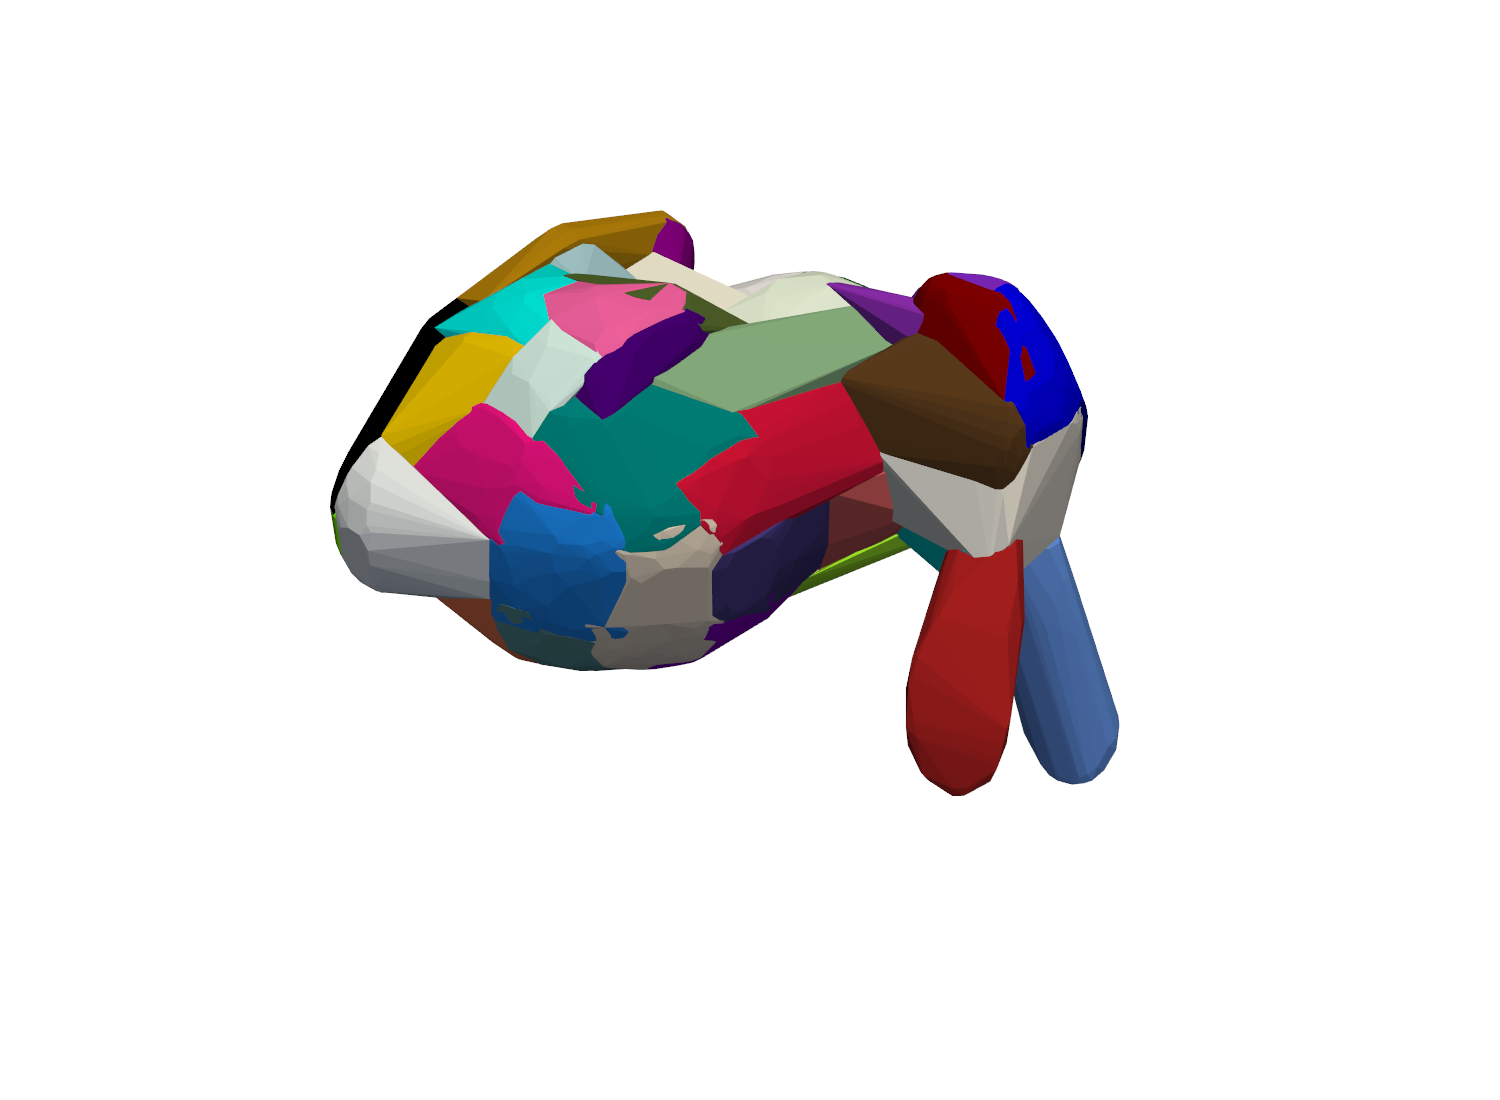

In [45]:
import pyvista
import pyVHACD

mesh = pyvista.examples.download_bunny().triangulate()

outputs = pyVHACD.compute_vhacd(mesh.points, mesh.faces)

plotter = pyvista.Plotter(window_size=(1500, 1100))
for i, (mesh_points, mesh_faces) in enumerate(outputs):
     plotter.add_mesh(pyvista.PolyData(mesh_points, mesh_faces), color=list(pyvista.hexcolors.keys())[i])

plotter.show()

In [48]:
mesh.points

pyvista_ndarray([[-0.0378297 ,  0.12794   ,  0.00447467],
                 [-0.0447794 ,  0.128887  ,  0.00190497],
                 [-0.0680095 ,  0.151244  ,  0.0371953 ],
                 ...,
                 [-0.0704544 ,  0.150585  , -0.0434585 ],
                 [-0.0310262 ,  0.153728  , -0.00354608],
                 [-0.0400442 ,  0.15362   , -0.00816685]], dtype=float32)